In [133]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# Get the data for the stock AAPL
df = yf.download('TSLA','2016-01-01','2020-01-01')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,15.381333,15.425333,14.600000,14.894000,14.894000,102406500
2016-01-05,15.090667,15.126000,14.666667,14.895333,14.895333,47802000
2016-01-06,14.666667,14.670000,14.398667,14.602667,14.602667,56686500
2016-01-07,14.279333,14.562667,14.244667,14.376667,14.376667,53314500
2016-01-08,14.524000,14.696000,14.051333,14.066667,14.066667,54421500
...,...,...,...,...,...,...
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500
2019-12-27,29.000000,29.020666,28.407333,28.691999,28.691999,149185500


In [134]:
df.reset_index(inplace=True)
df = df[['Date', 'Close']]
device = 'cpu'


/var/folders/dm/qkl8hp4j5338zb36dln1sxlw0000gn/T/ipykernel_61632/1541531171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


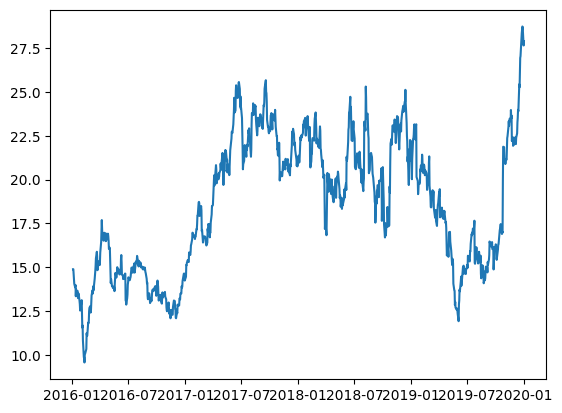

In [135]:
df['Date'] = pd.to_datetime(df['Date'])

plt.plot(df['Date'], df['Close'])


In [136]:
# Also shift the sentiment score of the previous days and implement it as a feature. 

from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df['Date'] = pd.to_datetime(df['Date'])

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close_(t-{i})'] = df['Close'].shift(i)
    
    df.dropna(inplace=True)

    return df

lookback = 5
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df.head()

,Close,Close_(t-1),Close_(t-2),Close_(t-3),Close_(t-4),Close_(t-5)
Date,,,,,,
2016-01-11,13.856667,14.066667,14.376667,14.602667,14.895333,14.894000
2016-01-12,13.998000,13.856667,14.066667,14.376667,14.602667,14.895333
2016-01-13,13.354000,13.998000,13.856667,14.066667,14.376667,14.602667
2016-01-14,13.745333,13.354000,13.998000,13.856667,14.066667,14.376667
2016-01-15,13.666000,13.745333,13.354000,13.998000,13.856667,14.066667


In [137]:
df_np = shifted_df.to_numpy()
df_np

array([[13.85666656, 14.0666666 , 14.37666702, 14.60266685, 14.89533329,
        14.89400005],
       [13.99800014, 13.85666656, 14.0666666 , 14.37666702, 14.60266685,
        14.89533329],
       [13.35400009, 13.99800014, 13.85666656, 14.0666666 , 14.37666702,
        14.60266685],
       ...,
       [28.69199944, 28.72933388, 28.35000038, 27.94799995, 27.03933334,
        26.93600082],
       [27.64666748, 28.69199944, 28.72933388, 28.35000038, 27.94799995,
        27.03933334],
       [27.88866615, 27.64666748, 28.69199944, 28.72933388, 28.35000038,
        27.94799995]])

In [138]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_np = scaler.fit_transform(df_np)
df_np

array([[-1.23372833, -1.17811518, -1.09620836, -1.03652983, -0.95915059,
        -0.95872124],
       [-1.19694596, -1.2328906 , -1.17724557, -1.09578449, -1.0361235 ,
        -0.95836959],
       [-1.3645484 , -1.19602582, -1.23214168, -1.17706317, -1.09556271,
        -1.03556435],
       ...,
       [ 2.62720003,  2.64642556,  2.55656052,  2.46246891,  2.23478909,
         2.21752093],
       [ 2.35515006,  2.63668742,  2.65572208,  2.56786897,  2.47377348,
         2.24477629],
       [ 2.41813075,  2.36402798,  2.64596249,  2.66732602,  2.57950183,
         2.48444952]])

In [139]:
y = df_np[:, 0]
X = df_np[:, 1:]
X = dc(np.flip(X, axis=1))

split_index = int(len(X) * 0.8)


In [140]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]


In [141]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))


In [142]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()



In [143]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [144]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [145]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 5, 1]) torch.Size([16, 1])


In [146]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [147]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [148]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [149]:
learning_rate = 0.0015
num_epochs = 32
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.634
***************************************************

Epoch: 2

Val Loss: 0.374
***************************************************

Epoch: 3

Val Loss: 0.258
***************************************************

Epoch: 4

Val Loss: 0.230
***************************************************

Epoch: 5

Val Loss: 0.203
***************************************************

Epoch: 6

Val Loss: 0.183
***************************************************

Epoch: 7

Val Loss: 0.170
***************************************************

Epoch: 8

Val Loss: 0.149
***************************************************

Epoch: 9

Val Loss: 0.138
***************************************************

Epoch: 10

Val Loss: 0.125
***************************************************

Epoch: 11

Val Loss: 0.117
***************************************************

Epoch: 12

Val Loss: 0.111
***************************************************

Epoch: 13

Val Loss: 0.107
**********************

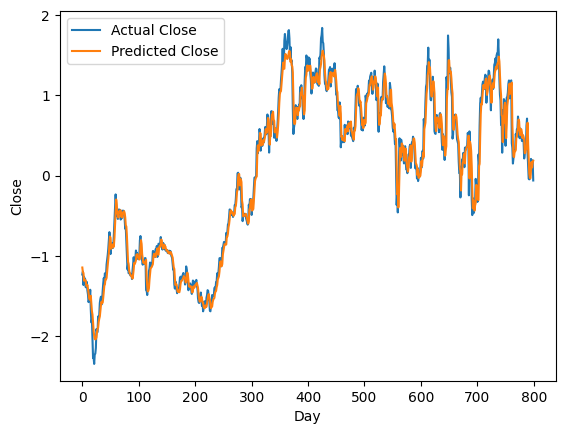

In [150]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

MSE: 0.023800259456038475
MAE: 0.1100568026304245


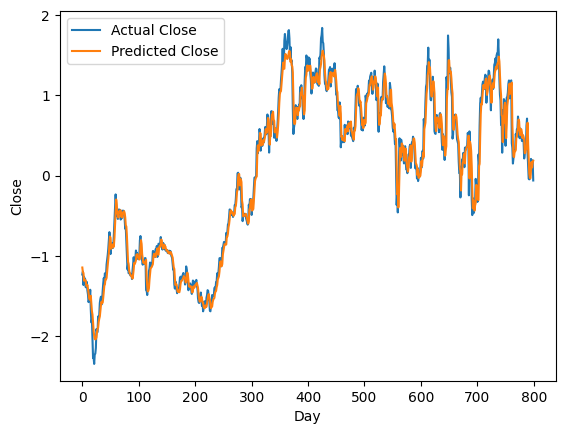

In [151]:
import torch
import torch.nn as nn
import numpy as np

def evaluate_predictions(actual, predicted):
    mse = nn.MSELoss()
    mae = nn.L1Loss()

    mse_score = mse(torch.Tensor(actual), torch.Tensor(predicted)).item()
    mae_score = mae(torch.Tensor(actual), torch.Tensor(predicted)).item()

    return mse_score, mae_score

# Assuming you have your model, training data, and plotting code ready
X_train = torch.Tensor(X_train)  # Assuming X_train is a numpy array
y_train = torch.Tensor(y_train)  # Assuming y_train is a numpy array

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

# Evaluate predictions
mse_score, mae_score = evaluate_predictions(y_train, predicted)

# Plotting code
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()

# Print evaluation scores
print(f"MSE: {mse_score}")
print(f"MAE: {mae_score}")